# Expectiles, learning rates, and learning stability

In [13]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.style as style; style.use('ggplot')

from expectiles import expectile
from gmm import GMM

## Example distribution

We'll want an example multi-modal distribution to play around with.

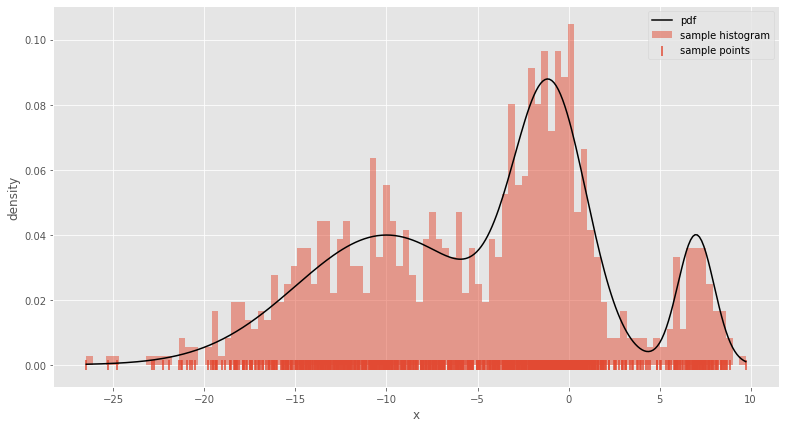

In [63]:
# create a mixture of gaussians
gmm = GMM(coeffs=[0.1, 0.4, 0.5], params=[[7, 1], [-1, 2], [-10, 5]])

# draw and a sample of 1000 points for us to play with
np.random.seed(seed=32)
sample = gmm.rvs(1000)

# plot the sample
plt.figure(figsize=(13, 7))
plt.hist(sample, density=1, bins=100, alpha=0.5, label="sample histogram")
plt.scatter(sample, np.zeros_like(sample), marker="|", s=100, label="sample points")
# plot pdf
x = np.linspace(sample.min(), sample.max(), 300)
y = gmm.pdf(x)
plt.plot(x, y, color="black", label="pdf")

plt.xlabel("x")
plt.ylabel("density")
plt.legend()
plt.show()

## Learning the mean

How can we learn expectiles over time by paying attention asymmetrically to positive and negative errors?

We can approximate the mean of a sample online by progressively updating an estimate as we see sample points.

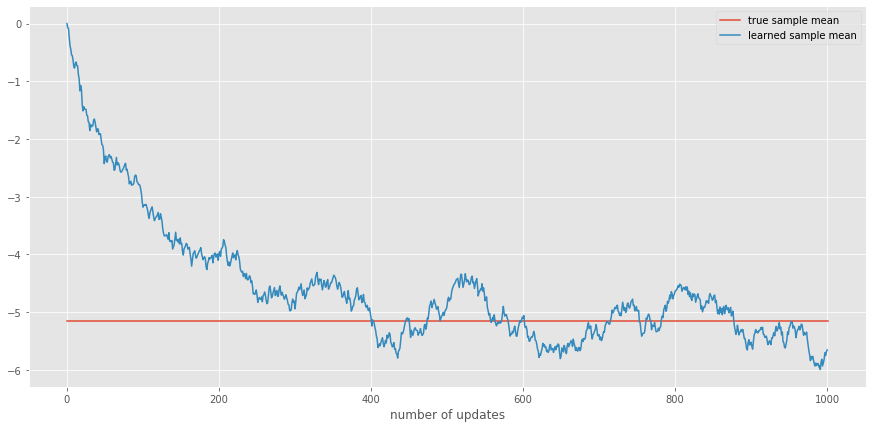

In [82]:
# compute the true sample mean offline
true_mean = np.mean(sample)

# or compute it online by updating in response to each sample we see
# (over time, the value will balance aroud the true sample mean)
pred_mean = np.zeros(sample.size+1)
learn_rate = 0.01
for t, x in enumerate(sample, 1):
    pred_error = x - pred_mean[t-1]
    pred_mean[t] = pred_mean[t-1] + learn_rate * pred_error

plt.figure(figsize=(15, 7))
plt.plot([0, sample.size+1], [true_mean, true_mean], label="true sample mean")
plt.plot(pred_mean, label="learned sample mean")
plt.xlabel("number of updates")
plt.legend()
plt.show()

### Setting the learning rate

The choice of learning rate is important because determines the balance between speed and stability in the learning process.

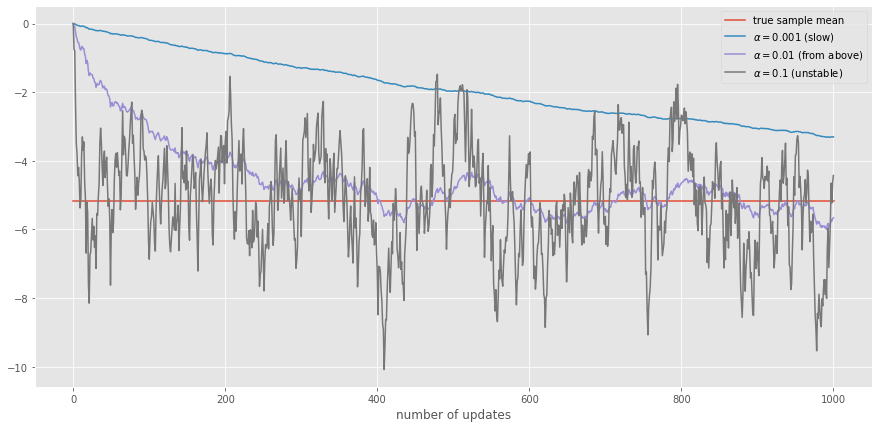

In [86]:
# recompute but with a much higher / lower learning rate:
pred_slow = np.zeros(sample.size+1)
pred_fast = np.zeros(sample.size+1)
learn_rate_slow = 0.001
learn_rate_fast = 0.1
for t, x in enumerate(sample, 1):
    pred_slow[t] = pred_slow[t-1] + learn_rate_slow * (x - pred_slow[t-1])
    pred_fast[t] = pred_fast[t-1] + learn_rate_fast * (x - pred_fast[t-1])

plt.figure(figsize=(15, 7))
plt.plot([0, sample.size+1], [true_mean, true_mean], label="true sample mean")
plt.plot(pred_slow, label=r"$\alpha=0.001$ (slow)")
plt.plot(pred_mean, label=r"$\alpha=0.01$ (from above)")
plt.plot(pred_fast, label=r"$\alpha=0.1$ (unstable)")
plt.xlabel("number of updates")
plt.legend()
plt.show()

## Learning other expectiles

We can do the same for other expectiles, too! We just have to use an *asymmetric* learning rate: a different learning rate for positive and negative error updates.

If we use:

* $\alpha_+$ in responding to positive prediction errors (values greater than the current estimate), and 
* $\alpha_-$ in responding to negative prediction errors (values less than the current estimate),

then the larned value should stabilise at expectile $\epsilon_\tau$ where:

$$\tau = \frac{\alpha_+}{\alpha_+ + \alpha_-}.\tag{1}$$

This happens because the learning process will need to move away from the mean to find an equilibrium where the number and scale of positive errors compared to negative errors counteracts the asymmetry in the positive and negative learning rates.

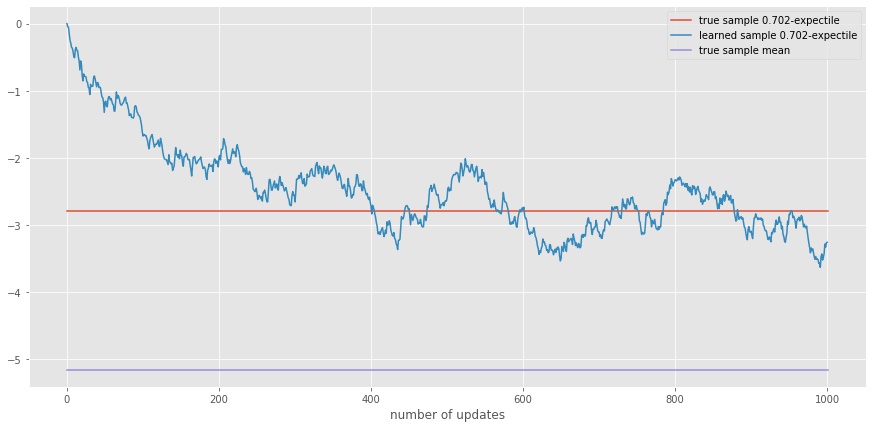

In [105]:
# a different learning rate for positive and negative errors
neg_learn_rate = 0.0065
pos_learn_rate = 0.0153
pred_expt = np.zeros(sample.size+1)
for i, x in enumerate(sample, 1):
    pred_error = x - pred_eps[i-1]
    if pred_error  > 0:
        # positive prediction error: sample higher than 'expected'
        pred_expt[i] = pred_expt[i-1] + pos_learn_rate * pred_error
    else:
        # negative prediction error: sample lower than 'expected'
        pred_expt[i] = pred_expt[i-1] + neg_learn_rate * pred_error

# the corresponding tau is given by equation (1)
tau = pos_learn_rate / (pos_learn_rate + neg_learn_rate) # ~= 0.702
true_expt = expectile(sample, tau)

plt.figure(figsize=(15, 7))
plt.plot([0, sample.size+1], [true_expt, true_expt], label=f"true sample {tau:.3f}-expectile")
plt.plot(pred_expt, label=f"learned sample {tau:.3f}-expectile")
plt.plot([0, sample.size+1], [true_mean, true_mean], label=f"true sample mean")
plt.xlabel("number of updates")
plt.legend()
plt.show()

### Setting the learning rates

From equation (1), if we want to learn a particular $\tau$-expectile, we can set the rates so that $\alpha_-\tau = \alpha_+(1 - \tau)$, or, equivalently,

$$\alpha_+ = \frac{\tau}{1-\tau}\alpha_-.\tag{2}$$

Just like before, it's important to set the learning rates to not be too high or too low. In this case, it's important that *neither* learning rate gets an extreme value. But, we still want them to have the multiplicative relationship defined in equation (2). One way to achieve this is to geometrically center the two learning rates around a reasonable 'base' learning rate $\alpha$, as follows:

$$
\alpha_- = \alpha \cdot \sqrt{\frac{1-\tau}{\tau}}
\qquad
\alpha_+ = \alpha \cdot \sqrt{\frac{\tau}{1-\tau}}
\tag{3}
$$

This scheme achieves (2) and results in a geometric average learning rate of $\alpha$ (averaged between the two rates, not over the course of learning). I hypothesise that this is a sensible scheme for achieving stable learning across the full range of possible $\tau$ values.

Let's try learning a full range of expectiles from the same sample!

learning...
plotting...


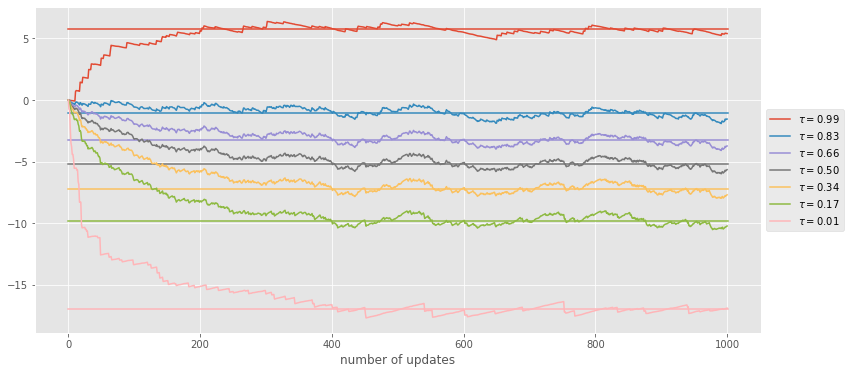

In [106]:
# compute the true expectile values offline
taus = np.linspace(0.01, 0.99, 7)
true_expts = expectile(sample, taus)

# configure learning rates
learn_rate_factors = np.sqrt(taus/(1-taus))
base_learn_rate = 0.01
neg_learn_rates = base_learn_rate / learn_rate_factors
pos_learn_rates = base_learn_rate * learn_rate_factors

print("learning...")
pred_expts = np.zeros((sample.size+1, taus.size))
for i, x in enumerate(sample, 1):
    pred_errors = x - pred_expts[i-1]
    
    # use negative update rate, except where error was positive
    learn_rates = neg_learn_rates.copy()
    pos_errors = np.where(pred_errors > 0)
    learn_rates[pos_errors] = pos_learn_rates[pos_errors]
    
    # with these rates, perform the update
    pred_expts[i] = pred_expts[i-1] + learn_rates * pred_errors

print("plotting...")
plt.figure(figsize=(13, 6))
for i, (tau, true_expt) in reversed(list(enumerate(zip(taus, true_expts)))):
    (line,) = plt.plot([0, sample.size+1], [true_expt, true_expt], label=r"$\tau={:.2f}$".format(tau))
    plt.plot(pred_expts[:, i], color=line.get_color())
plt.xlabel("number of updates")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

The effect of scheme (3) shown in the above plot is promising---the learning 'speed' and 'stability' appears uniform accross the range of values.

**This idea of setting the learning rates to be geometrically centred around $\alpha$ is crucial!**

Let's see what happens if we use the following non-centred rate-setting scheme instead:

$$
\alpha_- = \alpha 
\qquad
\alpha_+ = \alpha \cdot \frac{\tau}{1-\tau}
$$

(That is, set $\alpha_-$ to a uniform value regardless of $\tau$, and set $\alpha_+$ to a multiple of that value.)

learning...
plotting...


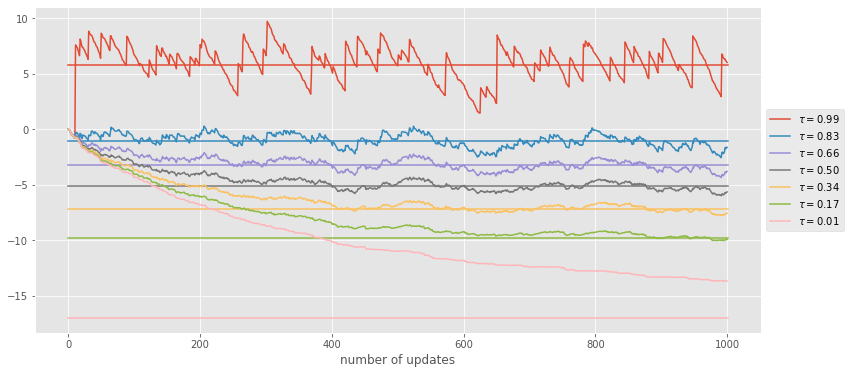

In [109]:
# configure learning rates
base_learn_rate = 0.01
neg_learn_rates = base_learn_rate * np.ones_like(taus)
pos_learn_rates = base_learn_rate * (taus/(1-taus))

print("learning...")
pred_expts = np.zeros((sample.size+1, taus.size))
for i, x in enumerate(sample, 1):
    pred_errors = x - pred_expts[i-1]
    
    # use negative update rate, except where error was positive
    learn_rates = neg_learn_rates.copy()
    pos_errors = np.where(pred_errors > 0)
    learn_rates[pos_errors] = pos_learn_rates[pos_errors]
    
    # with these rates, perform the update
    pred_expts[i] = pred_expts[i-1] + learn_rates * pred_errors

print("plotting...")
plt.figure(figsize=(13, 6))
for i, (tau, true_expt) in reversed(list(enumerate(zip(taus, true_expts)))):
    (line,) = plt.plot([0, sample.size+1], [true_expt, true_expt], label=r"$\tau={:.2f}$".format(tau))
    plt.plot(pred_expts[:, i], color=line.get_color())
plt.xlabel("number of updates")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

Though the system still shows learning stability near the middle of the $\tau$ range, the learning rates scheme deleteriously effects stability for non-mean expectiles. In the extremes, it causes very large updates for large $\tau$ (unstable learning) and very small updates for small $\tau$ ('overstable', inefficient learning).

Note that the general effect of this scheme is to take the learning rate from (3) and systematically scaled the positive and negative rates based on $\tau$, by a factor of $\sqrt{\frac{\tau}{1-\tau}}$. For small $\tau$ (close to 0), this is a very small number, leading to much smaller learning rates compared to scheme (3). For large $\tau$ (close to 1), this is a very large number, leading to much higher learning rates compared to scheme (3).

This difference can be seen by plotting $\alpha_+$ and $\alpha_-$ as a function of $\tau$ in each case:

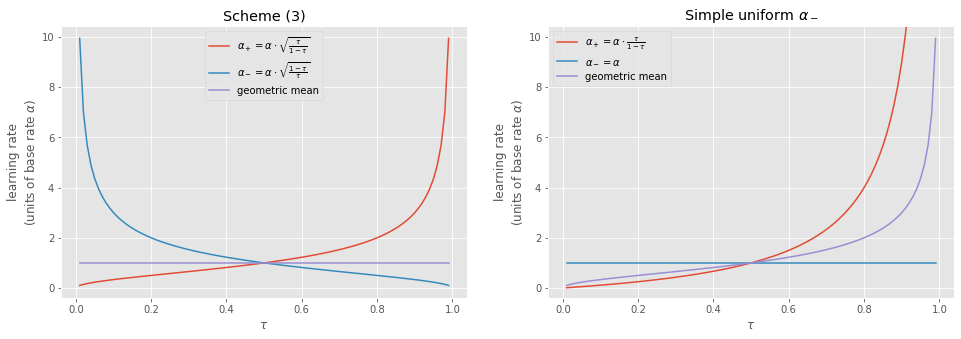

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
x = np.linspace(0.01, 0.99, 99)

y3 = x / (1-x)
y1 = np.sqrt(y3)
y2 = 1 / y1
y4 = np.ones_like(x)
m1 = np.sqrt(y1*y2)
m2 = np.sqrt(y3*y4)

ax1.plot(x, y1, label=r"$\alpha_+ = \alpha \cdot \sqrt{\frac{\tau}{1-\tau}}$")
ax1.plot(x, y2, label=r"$\alpha_- = \alpha \cdot \sqrt{\frac{1-\tau}{\tau}}$")
ax1.plot(x, m1, label="geometric mean")
ax2.plot(x, y3, label=r"$\alpha_+ = \alpha \cdot \frac{\tau}{1-\tau}$")
ax2.plot(x, y4, label=r"$\alpha_- = \alpha$")
ax2.plot(x, m2, label="geometric mean")

ax1.set_title("Scheme (3)")
ax1.set_xlabel(r"$\tau$")
ax1.set_ylabel("learning rate\n(units of base rate $\\alpha$)")
ax1.legend()
ax2.set_ylim(ax1.get_ylim())
ax2.set_title(r"Simple uniform $\alpha_-$")
ax2.set_xlabel(r"$\tau$")
ax2.set_ylabel("learning rate\n(units of base rate $\\alpha$)")
ax2.legend()

plt.show()

## Neural data

The deepmind paper [[1]] analysed a survey of 40 dopaminergic neurons from a few mice performing a learning task, and estimated the following asymmetric learning rates from the recorded response data.

[1]:   https://doi.org/10.1038/s41586-019-1924-6
[[1]]: *Dabney, W., Kurth-Nelson, Z., Uchida, N. et al. A distributional code for value in dopamine-based reinforcement learning. Nature 577, 671–675 (2020).*

In [114]:
# # code from deepmind notebook:
# # #
# fig5 = scipy.io.loadmat("Figure5.mat")
# zero_crossings = fig5['zeroCrossings'][:, 0]
# neg_scale, pos_scale = np.zeros(40), np.zeros(40)
# for cell in range(zero_crossings.shape[0]):
#     neg_scale[cell] = fig5['scaleFactNeg'][cell, 0]
#     pos_scale[cell] = fig5['scaleFactPos'][cell, 0]
# # #
# hard-coding data:
empirical_aneg = np.array(
    [ 1.09973087, 1.09434475, 0.81754647, 1.75496968, 1.67606203
    , 1.31782321, 4.2774962 , 2.07487821, 1.20795529, 1.79866939
    , 1.5543464 , 1.53714398, 1.75414581, 0.99157462, 1.25610374
    , 1.64890165, 1.11847172, 1.33288318, 1.06756076, 0.13837144
    , 3.18862819, 0.40993265, 1.57898859, 1.25206699, 0.7408865 
    , 1.37378935, 0.64970639, 0.5290385 , 1.15801591, 0.88804109
    , 0.39178265, 0.78761288, 0.9504729 , 0.78957621, 1.8922945 
    , 1.27743886, 0.89029917, 1.35846128, 0.24108255, 0.94215354
    ])
empirical_apos = np.array(
    [ 1.24414574, 1.69343895, 1.19657156, 1.48369474, 1.9833994 
    , 1.58354132, 0.35294234, 1.33308177, 1.05604004, 1.37478407
    , 0.78240602, 0.81737661, 0.59848422, 0.82444628, 1.01318986
    , 0.68250221, 1.0999396 , 0.98199883, 0.40079706,     np.nan # no pos. responses
    , 0.4510079 , 0.79450089, 1.92060389, 1.01949126, 2.06489026
    , 0.79670455, 0.56191573, 1.10647801, 0.69592584, 1.85254849
    , 1.05660636, 1.94111345, 2.16614124, 0.47228333, 1.30471873
    , 1.37844464, 1.20718559, 0.26307763, 1.13978478, 1.92823193
    ])

Let's see how these learning rates from *real mice neurons* measure up to the schemes hypothesised above!

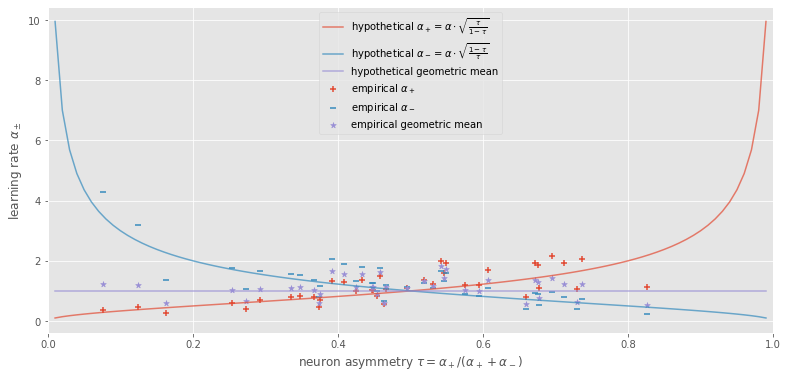

In [118]:
# If the neurons follow scheme (3) as outlined above,
# then we should see the following rates (in units
# of some base rate):
theory_taus = np.linspace(0.01, 0.99, 99)
theory_apos = np.sqrt(theory_taus / (1-theory_taus))
theory_aneg = 1 / theory_apos
theory_mean = np.ones_like(theory_taus) # = np.sqrt(theory_apos * theory_aneg)

# The experiment reveals the following:
empirical_apos = apos
empirical_aneg = aneg
empirical_taus = empirical_apos / (empirical_apos + empirical_aneg)
empirical_mean = np.sqrt(empirical_apos * empirical_aneg)

# let's see what happens!
plt.figure(figsize=(13, 6))
plt.plot(theory_taus, theory_apos, alpha=0.7, label=r"hypothetical $\alpha_+ = \alpha \cdot \sqrt{\frac{\tau}{1-\tau}}$")
plt.plot(theory_taus, theory_aneg, alpha=0.7, label=r"hypothetical $\alpha_- = \alpha \cdot \sqrt{\frac{1-\tau}{\tau}}$")
plt.plot(theory_taus, theory_mean, alpha=0.7, label="hypothetical geometric mean")
plt.scatter(empirical_taus, empirical_apos, marker="+", label=r"empirical $\alpha_+$")
plt.scatter(empirical_taus, empirical_aneg, marker="_", label=r"empirical $\alpha_-$")
plt.scatter(empirical_taus, empirical_mean, marker="*", label="empirical geometric mean")
plt.xlim([0, 1])
plt.xlabel(r"neuron asymmetry $\tau = \alpha_+ / (\alpha_+ + \alpha_-)$")
plt.ylabel(r"learning rate $\alpha_\pm$")
plt.legend()
# plt.savefig("learning_rate_stability.png")
plt.show()

That seems like one striking fit!

### Scaling

Come to think of it, the neural learning rates actually seem very high; it's not clear what the units are, but is it a coincidence that they seem to be geometrically centered around 1?